<a href="https://colab.research.google.com/github/ekingit/my_CNN_CIFAR/blob/main/CNN_CIFAR80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
#Main libs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

#Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

#Torchvision
import torchvision
from torchvision.utils import make_grid
from torchvision import datasets
from torchvision.transforms import v2

**Data Preprocessing**

In [27]:
#download the data and calculate mean and std. dev. for all RGB to 'normalize' the data
ds_train = datasets.CIFAR10('./data', train=True, download=True) # 50.000 PIL.image
ds_test = datasets.CIFAR10('./data', train=False, download=True)
ims_train = torch.tensor(ds_train.data) #tensor(50.000,32,32,3)
ims_train = ims_train.float() / 255. # tensor(50.000,32,32,3) -- 3x[0,1] RGB
mu=torch.mean(ims_train,[0,1,2]) # -> (3)
sigma=torch.std(ims_train,[0,1,2]) # -> (3)

Files already downloaded and verified
Files already downloaded and verified


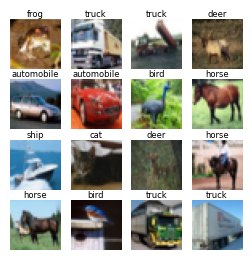

In [28]:
#looking at the data: 16 of 50.000 labeled pictures
labels = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
if __name__ == "__main__":
    fig, ax = plt.subplots(4,4,figsize=(3,3))
    for i, c_ax in enumerate(ax.flatten()):
        im, lab = ds_train[i]
        c_ax.imshow(im)
        c_ax.set_title(labels[lab],fontsize=6, y=0.88)
        c_ax.axis('off')

In [29]:
#v2 transformations for data augmantation
v2_train = v2.Compose([
    v2.Pad(4),
    v2.RandomResizedCrop(size=(32, 32), antialias=True),
    #v2.RandomHorizontalFlip(p=0.4),
    v2.ToImage(),
    #v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mu, sigma),
])
v2_test = v2.Compose([
    v2.ToImage(),
    #v2.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mu, sigma),
])

In [30]:
#data loaders:
ds_train_v2 = datasets.CIFAR10('./data', train=True, download=True, transform=v2_train)
ds_test_v2 = datasets.CIFAR10('./data', train=False, download=True, transform=v2_test)
dl_train = DataLoader(ds_train_v2, batch_size=128,shuffle=True) #50.000 item = 128*390.625 = 128*390+80
dl_test = DataLoader(ds_test_v2, batch_size=128,shuffle=True) #10.000 item = 128*78.125 = 128*78+16

Files already downloaded and verified
Files already downloaded and verified


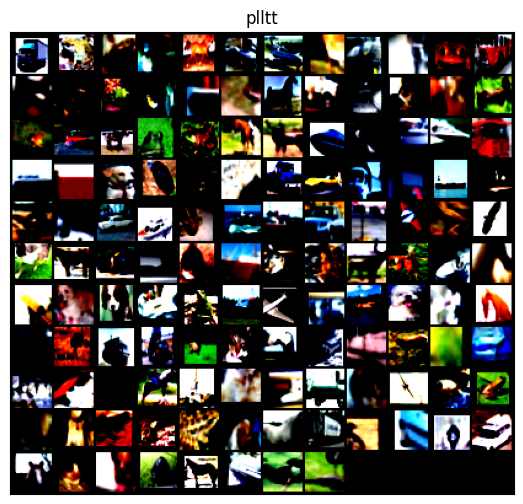

In [31]:
# looking at the data after the augmentation
if __name__ == "__main__":
    for images, labels in dl_train:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=12).permute(1, 2, 0))
        break

In [32]:
# Defining layers
class CNN(nn.Module): #(batch_size=128,3,32,32) --> (batch_size,10)
    def __init__(self):
        super(CNN, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2) # (A,B,C,C)-> (A,B,C/2,C/2)
        self.act = nn.ReLU() # tens -> tens
        self.drop = nn.Dropout(0.1) # tens -> tens

        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,padding=1)   # (128,3,A,A)  --> (128,64,A,A)
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1)  # (128,64,A,A) --> (128,64,A,A)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)  # (128,64,A,A) --> (128,128,A,A)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1)  # (128,128,A,A) --> (128,128,A,A)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1) # (128,128,A,A) --> (128,256,A,A)
        self.conv6 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1) # (128,256,A,A) --> (128,256,A,A)

        self.lp1 = nn.Linear(4096,128) # (128,4096) --> (128,128)
        self.lp2 = nn.Linear(128,10)   #  (128,128) --> (128,10)

    def forward(self, X):
        X = self.drop(self.act(self.conv1(X))) #(128,3,32,32) --> (128,64,32,32)
        X = self.drop(self.act(self.pool(self.conv2(X)))) #(128,64,32,32) --> (128,64,16,16)
        X = self.drop(self.act(self.pool(self.conv3(X)))) #(128,64,16,16) --> (128,128,8,8)
        X = self.drop(self.act(self.conv4(X))) # (128,128,8,8) --> (128,128,8,8)
        X = self.drop(self.act(self.pool(self.conv5(X)))) #(128,128,8,8) --> (128,256,4,4)
        X = self.drop(self.act(self.conv6(X))) # (128,256,4,4) --> (128,256,4,4)
        X = torch.flatten(X,1) # (128,128,4,4) --> (128, 4096)
        X = self.drop(self.act(self.lp1(X))) # --> (4096,64)
        X = F.log_softmax(self.lp2(X),dim=1) # --> (128,10)
        return X # softmax normalizes X \in R^10, log returns a negative value


In [33]:
def train(model, dl_train, optimizer, epoch, log_interval=100, device='cpu'):

    model.train() #from nn.Module
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(dl_train):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data) #(batch_size,3,32,32) --> (10)
        batch_loss = F.nll_loss(output, target) #(10x10) --> 1
        batch_loss.backward() #calculates gradients
        optimizer.step() #updates weights and kernels
        train_loss += batch_loss.detach().item()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item() # get the correct predictions

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl_train.dataset),
                100. * batch_idx / len(dl_train), batch_loss))
    correct = 100. * correct / len(dl_train.dataset)
    train_loss /= len(dl_train)
    trainloss.append(train_loss)
    trainacc.append(correct)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        train_loss, correct, len(dl_train.dataset),
        correct))


In [34]:
def test(model, dl_test, device='cpu'):

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # no need to track gradients. Saves memory.
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data) # Forward pass
            batch_loss = F.nll_loss(output,target)
            test_loss += batch_loss.detach().item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # get the correct predictions

    test_loss /= len(dl_test)
    testloss.append(test_loss)
    correct = 100. * correct / len(dl_test.dataset)
    testacc.append(correct)
    print('\nTest set - Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(dl_test.dataset),
        correct))

In [35]:
torch.manual_seed(4321) #fixes initial weights and kernels to test different models/hyperparameters

device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # additional speed up

model = CNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9,
weight_decay=5e-5)
criterion = nn.CrossEntropyLoss()


scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
model = model.to(device)

In [36]:
# run()
a = time.time()
trainloss = []
testloss = []
trainacc = []
testacc = []
epochs = 50
for epoch in range(0, epochs):
    train(model, dl_train, optimizer, epoch+1, log_interval=100, device=device)
    test(model, dl_test, device=device)
    scheduler.step()

b = time.time()
print('\nTraining took ' + str(np.round(b - a, 2)) + ' seconds.\n\n')

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.309876
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.301260
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.260700
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.109853

Train set: Average loss: 2.2028, Accuracy: 15.79/50000 (15.8%)


Test set - Average loss: 1.9697, Accuracy: 26.25/10000 (26.250%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.102659
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.014986
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.951412
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.880568

Train set: Average loss: 1.9509, Accuracy: 25.75/50000 (25.8%)


Test set - Average loss: 1.7499, Accuracy: 34.29/10000 (34.290%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.892780
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.888935
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.730024
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.691340

Train set: Average loss: 1.8126, Accuracy: 32.422/50000 (32.4%)


Test set - Average loss: 1.5820, Accuracy: 42.41/10000 (42.410%)

Train Epoch: 4 [0/

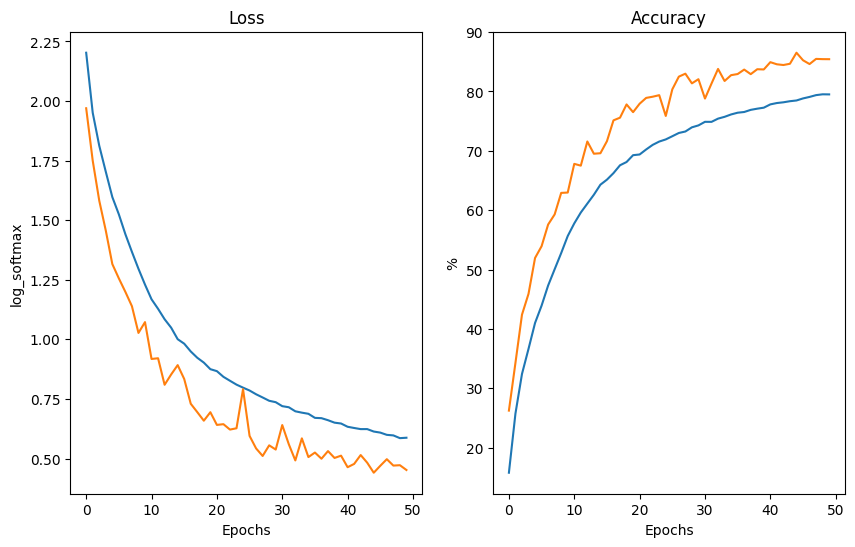

In [39]:
x = 'Epochs'

plt.subplot(1,2,1)
plt.plot(trainloss, label='train_loss')
plt.plot(testloss, label='val_loss')
plt.title('Loss')
plt.ylabel('log_softmax')
plt.xlabel(x)

plt.subplot(1, 2, 2)
plt.plot(trainacc, label='train_acc')
plt.plot(testacc,label='val_acc')
plt.title('Accuracy')
plt.ylabel('%')
plt.xlabel(x)
plt.rcParams["figure.figsize"] = (15,6)
plt.show()

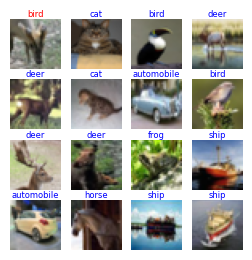

In [41]:
#looking at the predictions
labels = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
if __name__ == "__main__":
    rand = torch.randint(10000,(16,1))
    # ds_test = ds_test.to(device)
    # ds_test_v2 = ds_test_v2.to(device)
    fig, ax = plt.subplots(4,4,figsize=(3,3))
    for i, c_ax in enumerate(ax.flatten()):
        ex_num = rand[i].item()
        var1 = ds_test_v2[ex_num][0].reshape(1,3,32,32)
        var1 = var1.to(device)
        var2 = (ds_test[ex_num][0])
        im = (ds_test_v2[ex_num][1])
        pred = model(var1)
        pred = pred.argmax(dim=1, keepdim=True)
        lab = pred.item()
        if ds_test_v2[rand[i].item()][1]==pred:
            c_ax.set_title((labels[lab]),fontsize=6,color='blue', y=0.88)
        else:
            c_ax.set_title(labels[lab],fontsize=6,color='red', y=0.88)
        c_ax.imshow(var2)
        c_ax.axis('off')